# Multi-Dimensional Scaling (MDS)

MDS is a technique to translate distances between every pair of data points into an abstract cartesian space, wherein the distances of the original space are optimized to be as similar as possible. For instance, given that two data points $\mathbf{x}_i$ and $\mathbf{x}_j$ are elements of the vector space $\mathbb{R}^n$, where $n$ is large, it can be difficult to understand the underlying geometry of the data. Often linear methods are used, such as Principal Component Analysis (PCA), to linearly project the data onto a low-dimensional space. However, the data may have a non-trivial high-dimensional structure, meaning that linear projections just are not good enough. 

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.datasets import load_digits

X_numpy, y_numpy = load_digits(return_X_y=True)

X_numpy.shape, y_numpy.shape

((1797, 64), (1797,))

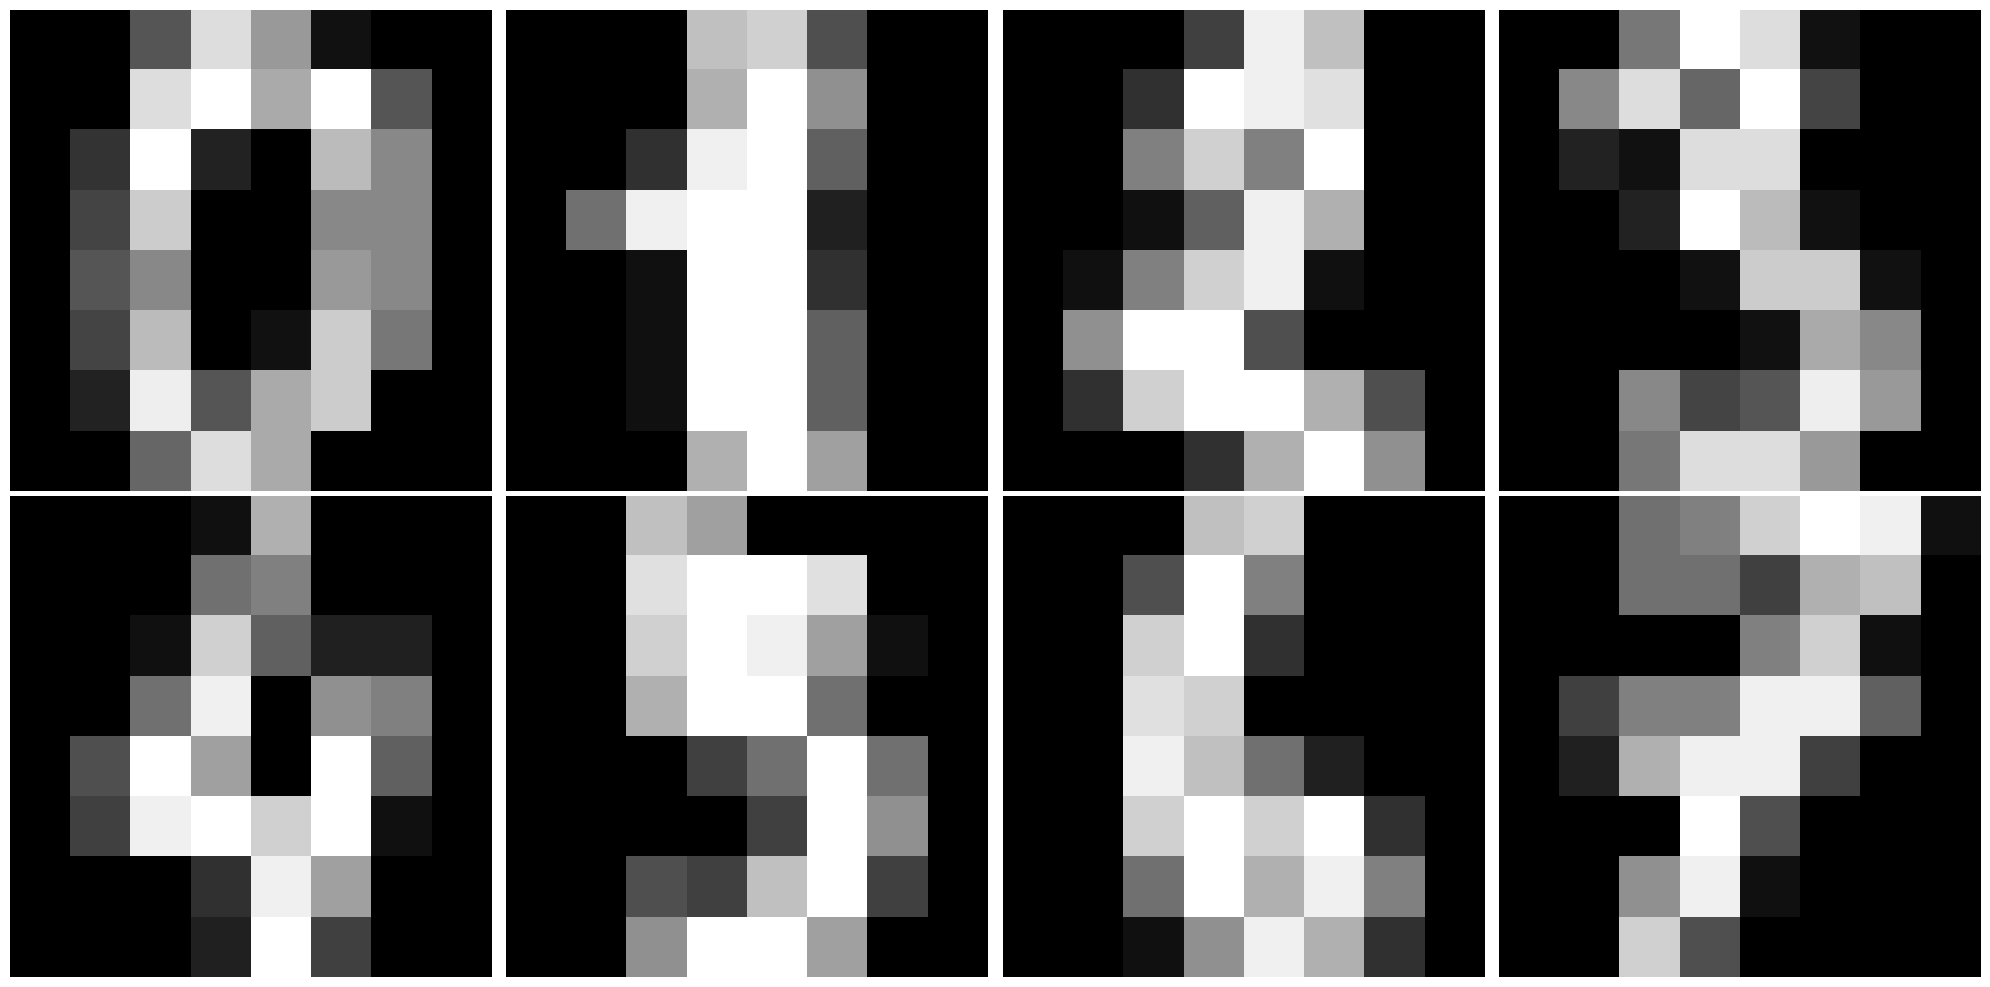

In [3]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(X_numpy[i].reshape(8, 8), cmap='gray')
    ax.axis('off')

plt.tight_layout()

## Key idea behind MDS

The idea behind MDS is to first define for each data point $\mathbf{x}_i$ in the original high-dimensional dataset, a randomly initialized low-dimensional counterpart $\hat{\mathbf{x}}_i$. Thereafter, for both the original dataset $X$ and the randomly initialized low-dimensional counterpart $\hat{X}$, the distance between each pair of data points in computed. There are many distance functions, but for now the Euclidean distance is used between every pair of data points:
$$
    d_{ij} = \sqrt{\sum_{k} (\mathbf{x}_{ik} - \mathbf{x}_{jk})^2}, \qquad \hat{d}_{ij} = \sqrt{\sum_{k} (\hat{\mathbf{x}}_{ik} - \hat{\mathbf{x}}_{jk})^2}
$$
We want the low-dimensional distances $\hat{d}_{ij}$ to closely match the high-dimensional distances $d_{ij}$. The mean-squared error provides a way to quantify the discrepancy between geometry. 
$$
    \mathcal{L} = \sum_{i \neq j} (\hat{d}_{ij} - d_{ij})^2
$$
We just formulated an optimization task, which can be iteratively refined via gradient descent. 

In [4]:
X = torch.tensor(X_numpy)
X_manifold = torch.randn(X.shape[0], 2, requires_grad=True)

# adam + really high learning rate
optim = torch.optim.Adam([X_manifold], lr=50.8)

# original distance matrix only needs to be computed once
dist_original = torch.norm(X[..., None, :] - X[None, ...], p=2, dim=2)

# optimize for 200 iterations
for i in range(200):

    dist_manifold = torch.norm(X_manifold[..., None, :] - X_manifold[None, ...], p=2, dim=2)

    # compute loss
    L = torch.sum((dist_manifold - dist_original)**2)
    if i % 10 == 0: print(f"Iter: {i}, loss: {L.item()}")

    # backprop
    optim.zero_grad()
    L.backward()
    optim.step()

Iter: 0, loss: 7224690136.543937
Iter: 10, loss: 1629552377.3397784
Iter: 20, loss: 1798070169.8321645
Iter: 30, loss: 1414262948.2658358
Iter: 40, loss: 1247236448.6111927
Iter: 50, loss: 992903293.4685717
Iter: 60, loss: 894855247.8814766
Iter: 70, loss: 857744460.6064806
Iter: 80, loss: 842180414.9626746
Iter: 90, loss: 836142417.6731005
Iter: 100, loss: 834230043.9620066
Iter: 110, loss: 833441430.9484711
Iter: 120, loss: 833181782.0997536
Iter: 130, loss: 833074889.3576959
Iter: 140, loss: 832932589.2458673
Iter: 150, loss: 832143495.0221736
Iter: 160, loss: 832199346.5946046
Iter: 170, loss: 832140813.2942983
Iter: 180, loss: 832108536.4055822
Iter: 190, loss: 832095524.5055254


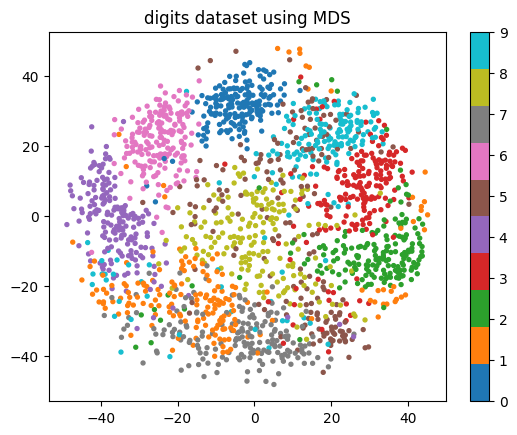

In [5]:
plt.title("digits dataset using MDS")
plt.scatter(X_manifold[:, 0].detach().numpy(), X_manifold[:, 1].detach().numpy(), c=y_numpy, s=8, cmap='tab10')
cbar = plt.colorbar()

## Comparison with PCA

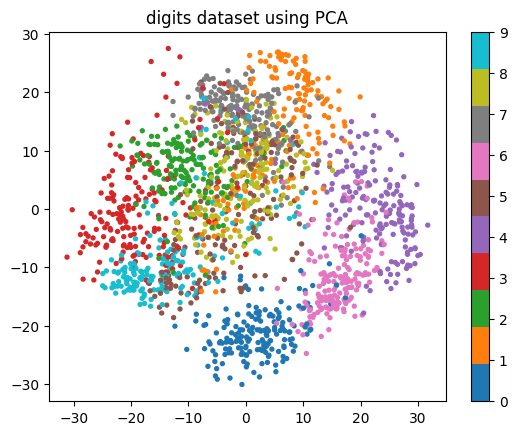

In [6]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(X_numpy)

plt.title("digits dataset using PCA")
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_numpy, s=8, cmap='tab10')
cbar = plt.colorbar()

## Comparison with Sklearn's MDS

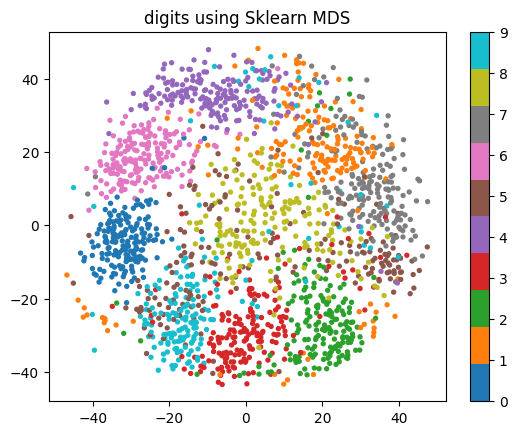

In [7]:
from sklearn.manifold import MDS

X_mds = MDS(n_components=2, normalized_stress='auto').fit_transform(X_numpy)

plt.title("digits using Sklearn MDS")
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=y_numpy, s=8, cmap='tab10')
cbar = plt.colorbar()

## Sammon's mapping

Defines a loss emphasizing local structure as more important to maintain than global structure
$$
    \mathcal{L} = \sum_{i \neq j} \dfrac{(\hat{d}_{ij} - d_{ij})^2}{d_{ij}}
$$

In [8]:
X = torch.tensor(X_numpy)
X_sammon = torch.randn(X.shape[0], 2, requires_grad=True)

# adam + really high learning rate
optim = torch.optim.Adam([X_sammon], lr=50.8)

# original distance matrix only needs to be computed once
dist_original = torch.norm(X[..., None, :] - X[None, ...], p=2, dim=2)

# optimize for 200 iterations
for i in range(200):

    dist_manifold = torch.norm(X_sammon[..., None, :] - X_sammon[None, ...], p=2, dim=2)

    # compute loss
    L = torch.sum((dist_manifold - dist_original)**2 / (dist_original + 1e-6))
    if i % 10 == 0: print(f"Iter: {i}, loss: {L.item()}")

    # backprop
    optim.zero_grad()
    L.backward()
    optim.step()

Iter: 0, loss: 144941705.83252326
Iter: 10, loss: 34158578.710112825
Iter: 20, loss: 38756132.70583868
Iter: 30, loss: 29703228.480433546
Iter: 40, loss: 25452257.295969978
Iter: 50, loss: 20608227.052047603
Iter: 60, loss: 18954488.761349365
Iter: 70, loss: 18520321.08252172
Iter: 80, loss: 18309493.251379855
Iter: 90, loss: 18241005.63577147
Iter: 100, loss: 18216802.21515567
Iter: 110, loss: 18206689.621605642
Iter: 120, loss: 18203047.82022094
Iter: 130, loss: 18201574.37497747
Iter: 140, loss: 18201012.092302456
Iter: 150, loss: 18200826.36634105
Iter: 160, loss: 18200762.923830036
Iter: 170, loss: 18200739.99118711
Iter: 180, loss: 18200731.65838342
Iter: 190, loss: 18200725.237556495


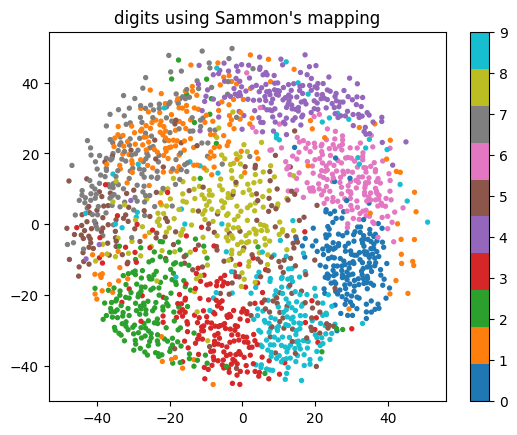

In [9]:
plt.title("digits using Sammon's mapping")
plt.scatter(X_sammon[:, 0].detach().numpy(), X_sammon[:, 1].detach().numpy(), c=y_numpy, s=8, cmap='tab10')
cbar = plt.colorbar()

## Nearest Neighbour Graph visualization

$$
    \mathcal{L} = \sum_{i \neq j} \frac{1}{\hat{d}_{ij}} + \frac{1}{2} \sum_{(i, j) \in E} (\hat{d}_{ij} - d_{ij})^2
$$

In [34]:
dist_original.shape[0] * 0.2

359.40000000000003

In [56]:
k = 23

X = torch.tensor(X_numpy)
X_nn = torch.randn(X.shape[0], 2, requires_grad=True)

# adam + really high learning rate
optim = torch.optim.Adam([X_nn], lr=5.8)

# original distance matrix only needs to be computed once
dist_original = torch.norm(X[..., None, :] - X[None, ...], p=2, dim=2)
idx = dist_original.argsort(dim=0)
dist_original_sorted = torch.take_along_dim(dist_original, idx, dim=0)
dist_original_nn = dist_original_sorted[1:k+1, :] # take only the k nearest neighbours

history = []

for i in range(200):

    dist_manifold = torch.norm(X_nn[..., None, :] - X_nn[None, ...], p=2, dim=2)
    idx = dist_manifold.argsort(dim=0)
    dist_manifold_sorted = torch.take_along_dim(dist_manifold, idx, dim=0)
    dist_manifold_nn = dist_manifold_sorted[1:k+1, :] # take only the k nearest neighbours

    # compute loss
    L = torch.sum(1/(dist_manifold + 1e-8)) + 0.5 * torch.sum((dist_manifold_nn - dist_original_nn)**2)
    
    if i % 10 == 0: print(f"Iter: {i}, loss: {L.item()}")

    history.append(L.item())

    # backprop
    optim.zero_grad()
    L.backward()
    optim.step()

Iter: 0, loss: 179714239323.40515
Iter: 10, loss: 179707390714.82095
Iter: 20, loss: 179705383752.34555
Iter: 30, loss: 179704336555.38956
Iter: 40, loss: 179703720198.1765
Iter: 50, loss: 179703265714.56955
Iter: 60, loss: 179702916890.9239
Iter: 70, loss: 179702616827.52744
Iter: 80, loss: 179702356318.75296
Iter: 90, loss: 179702123100.4883
Iter: 100, loss: 179701918534.67062
Iter: 110, loss: 179701738382.93835
Iter: 120, loss: 179701559043.40656
Iter: 130, loss: 179701414697.02246
Iter: 140, loss: 179701287296.55478
Iter: 150, loss: 179701177355.84018
Iter: 160, loss: 179701082908.4918
Iter: 170, loss: 179700999782.08923
Iter: 180, loss: 179700926158.30743
Iter: 190, loss: 179700861981.16385


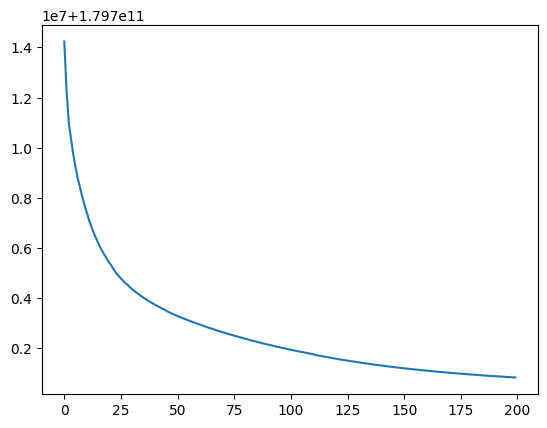

In [57]:
plt.plot(history)

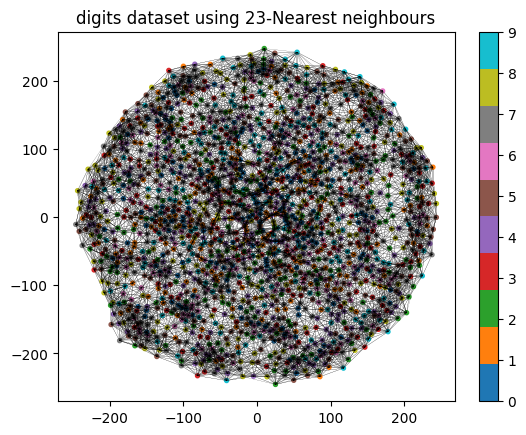

In [59]:
X_nn_np = X_nn.detach().numpy()

plt.title(f"digits dataset using {k}-Nearest neighbours")

dist_manifold = torch.norm(X_nn[..., None, :] - X_nn[None, ...], p=2, dim=2)
idx = dist_manifold.argsort(dim=0)
dist_manifold_sorted = torch.take_along_dim(dist_manifold, idx, dim=0)
dist_manifold_nn = dist_manifold_sorted[1:k, :]

for j, idx_row in enumerate(idx[1:k, :].T):
    for i in idx_row:
        i = i.item()
        plt.plot([X_nn_np[j, 0], X_nn_np[i, 0]], [X_nn_np[j, 1], X_nn_np[i, 1]], c='k', linewidth=0.1)

plt.scatter(X_nn_np[:, 0], X_nn_np[:, 1], c=y_numpy, s=8, cmap='tab10')
cbar = plt.colorbar()

plt.show()

### Breast cancer dataset

In [13]:
from sklearn.datasets import load_breast_cancer

X_bc, y_bc = load_breast_cancer(return_X_y=True)

X_bc.shape, y_bc.shape

((569, 30), (569,))

In [14]:
k = 3

X = torch.tensor(X_bc)
X_nn = torch.randn(X.shape[0], 2, requires_grad=True)

# adam + really high learning rate
optim = torch.optim.Adam([X_nn], lr=0.5)

# original distance matrix only needs to be computed once
dist_original = torch.norm(X[..., None, :] - X[None, ...], p=2, dim=2)
idx = dist_original.argsort(dim=0)
dist_original_sorted = torch.take_along_dim(dist_original, idx, dim=0)
dist_original_nn = dist_original_sorted[1:k+1, :] # take only the k nearest neighbours

history = []

# optimize for 200 iterations
for i in range(1000):

    dist_manifold = torch.norm(X_nn[..., None, :] - X_nn[None, ...], p=2, dim=2)
    idx = dist_manifold.argsort(dim=0)
    dist_manifold_sorted = torch.take_along_dim(dist_manifold, idx, dim=0)
    dist_manifold_nn = dist_manifold_sorted[1:k+1, :] # take only the k nearest neighbours

    # compute loss
    L = torch.sum(1/(dist_manifold + 1e-8)) + 0.5 * torch.sum((dist_manifold_nn - dist_original_nn)**2)
    
    if i % 100 == 0: print(f"Iter: {i}, loss: {L.item()}")

    history.append(L.item())

    # backprop
    optim.zero_grad()
    L.backward()
    optim.step()

Iter: 0, loss: 56906919493.095314
Iter: 100, loss: 56906233005.72569
Iter: 200, loss: 56905809125.13045
Iter: 300, loss: 56905420989.52424
Iter: 400, loss: 56905057900.74286
Iter: 500, loss: 56904727143.56136
Iter: 600, loss: 56904435417.885185
Iter: 700, loss: 56904175668.75978
Iter: 800, loss: 56903931826.94907
Iter: 900, loss: 56903691689.83839


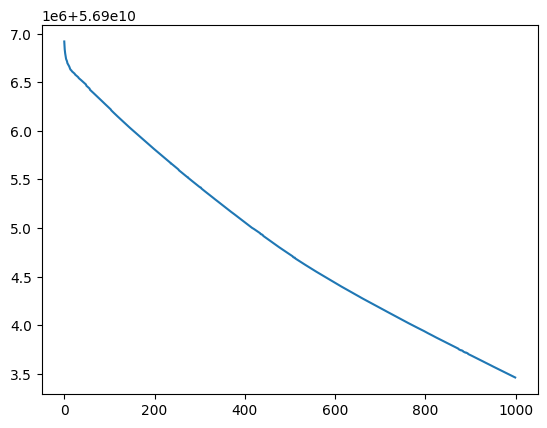

In [15]:
plt.plot(history)

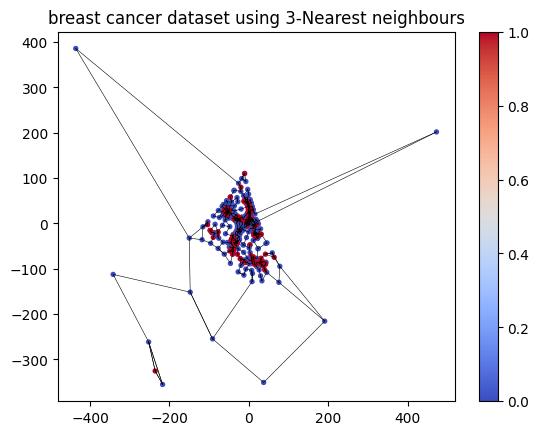

In [16]:
X_nn_np = X_nn.detach().numpy()

plt.title("breast cancer dataset using 3-Nearest neighbours")

dist_manifold = torch.norm(X_nn[..., None, :] - X_nn[None, ...], p=2, dim=2)
idx = dist_manifold.argsort(dim=0)
dist_manifold_sorted = torch.take_along_dim(dist_manifold, idx, dim=0)
dist_manifold_nn = dist_manifold_sorted[1:k, :]

for j, idx_row in enumerate(idx[1:k, :].T):
    for i in idx_row:
        i = i.item()
        plt.plot([X_nn_np[j, 0], X_nn_np[i, 0]], [X_nn_np[j, 1], X_nn_np[i, 1]], c='k', linewidth=0.4)

plt.scatter(X_nn_np[:, 0], X_nn_np[:, 1], c=y_bc, s=8, cmap='coolwarm')
cbar = plt.colorbar()

## t-SNE

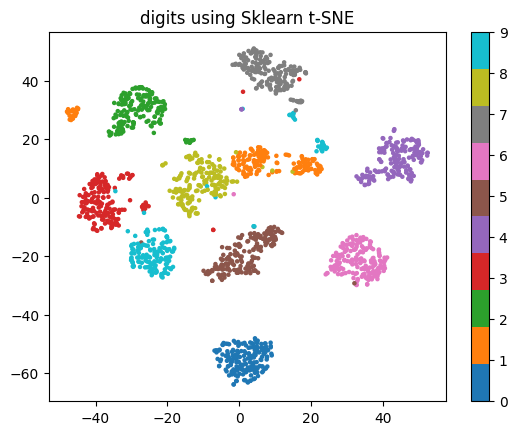

In [61]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2).fit_transform(X_numpy)

plt.title("digits using Sklearn t-SNE")
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_numpy, s=5, cmap='tab10')
cbar = plt.colorbar()